# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",1000)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl

rm: cannot remove 'dataset/tf_vae_dense_trained_together_nsl_kdd_all-.pkl': No such file or directory


In [3]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [4]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [5]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [6]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.std()

0.97509982675167528

In [7]:
import tensorflow as tf


In [8]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            loss = tf.clip_by_value(loss, -1e-4, 1e-4)
            loss = tf.where(tf.is_nan(loss), 1e-4, loss)
            loss = tf.where(tf.equal(loss, -1e-4), tf.random_normal(loss.shape), loss)
            loss = tf.where(tf.equal(loss, 1e-4), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [9]:
import collections
import time
import sklearn.metrics as me 

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.2)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                        train_batch()
                        count = 10
                        
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_{}_features count_{}'
                                                                         .format(h,f)))
                            train_batch()
                            count -= 1

                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})
                    
                    test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test, 
                                                                                     net.y_: preprocess.y_test, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    
                    f1_score = me.f1_score(actual_value, pred_value)
                    test_accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test_, 
                                                                                     net.y_: preprocess.y_test_, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    #summary_writer_valid.add_summary(summary_str, epoch)

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(test_accuracy, test_accuracy_))

                    if test_accuracy > Train.best_acc_global:
                        Train.best_acc_global = test_accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if test_accuracy > Train.best_acc:
                        Train.best_acc = test_accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, test_accuracy, f1_score, test_accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, test_accuracy, f1_score, test_accuracy_, f1_score_, time.perf_counter() - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [10]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        Train.predictions = {}
        Train.predictions_ = {}
        Train.results = []

        epochs = [15]
        lrs = [1e-2, 1e-2]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        
        if not os.path.isfile('dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
                
        past_scores.to_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl")


In [11]:
#%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:1 features count:1
Step 1 | Training Loss: 0.000665 | Validation Accuracy: 0.652113
Accuracy on Test data: 0.6522799730300903, 0.6925738453865051
Step 2 | Training Loss: 0.000305 | Validation Accuracy: 0.815836
Accuracy on Test data: 0.716864824295044, 0.48877638578414917
Step 3 | Training Loss: 0.000190 | Validation Accuracy: 0.802540
Accuracy on Test data: 0.7153566479682922, 0.5171307921409607
Step 4 | Training Loss: 0.000305 | Validation Accuracy: 0.773963
Accuracy on Test data: 0.7897001504898071, 0.7081856727600098
Step 5 | Training Loss: 0.000015 | Validation Accuracy: 0.752133
Accuracy on Test data: 0.7259137630462646, 0.6094514727592468
Step 6 | Training Loss: 0.000042 | Validation Accuracy: 0.818218
Accuracy on Test data: 0.7488910555839539, 0.598143458366394
Step 7 | Training Loss: 0.000106 | Validation Accuracy: 0.742012
Accuracy on Test data: 0.6262863874435425, 0.45603376626968384
Step 8 | Training Loss: 0.000142 | Valida

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 2 | Training Loss: 0.012218 | Validation Accuracy: 0.542568
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 1.805758 | Validation Accuracy: 0.538599
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 1.564975 | Validation Accuracy: 0.541774
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.934638 | Validation Accuracy: 0.525700
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.153852 | Validation Accuracy: 0.528279
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.682114 | Validation Accuracy: 0.544751
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 0.747098 | Validation Accuracy: 0.530859
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.797108 | Validation Accuracy: 0.534431
Accuracy on Test data: 0.4307576

Step 4 | Training Loss: 1.076023 | Validation Accuracy: 0.542766
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.046245 | Validation Accuracy: 0.518357
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.521358 | Validation Accuracy: 0.529272
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.107319 | Validation Accuracy: 0.526295
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 1.585423 | Validation Accuracy: 0.540187
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 1.665708 | Validation Accuracy: 0.530661
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 10 | Training Loss: 1.072209 | Validation Accuracy: 0.521334
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 11 | Training Loss: 0.860059 | Validation Accuracy: 0.529867
Accuracy on Test data: 0.43075

Step 6 | Training Loss: 0.000046 | Validation Accuracy: 0.668783
Accuracy on Test data: 0.6443843245506287, 0.46928268671035767
Step 7 | Training Loss: 0.000046 | Validation Accuracy: 0.681484
Accuracy on Test data: 0.6622604727745056, 0.5103797316551208
Step 8 | Training Loss: 0.000096 | Validation Accuracy: 0.667196
Accuracy on Test data: 0.6324077248573303, 0.47578057646751404
Step 9 | Training Loss: 0.000156 | Validation Accuracy: 0.694979
Accuracy on Test data: 0.7618878483772278, 0.647763729095459
Step 10 | Training Loss: 0.000062 | Validation Accuracy: 0.709069
Accuracy on Test data: 0.7138928174972534, 0.5889451503753662
Step 11 | Training Loss: 0.000121 | Validation Accuracy: 0.737249
Accuracy on Test data: 0.7503548860549927, 0.6370463967323303
Step 12 | Training Loss: 0.000149 | Validation Accuracy: 0.706489
Accuracy on Test data: 0.697613537311554, 0.5612658262252808
Step 13 | Training Loss: 0.000105 | Validation Accuracy: 0.673348
Accuracy on Test data: 0.6672285199165344,

Step 9 | Training Loss: 0.000141 | Validation Accuracy: 0.903751
Accuracy on Test data: 0.8419091701507568, 0.751139223575592
Step 10 | Training Loss: 0.000025 | Validation Accuracy: 0.926771
Accuracy on Test data: 0.8447036743164062, 0.7358649969100952
Step 11 | Training Loss: 0.000121 | Validation Accuracy: 0.906331
Accuracy on Test data: 0.8088626861572266, 0.7099577784538269
Step 12 | Training Loss: 0.000034 | Validation Accuracy: 0.915261
Accuracy on Test data: 0.7733321785926819, 0.594936728477478
Step 13 | Training Loss: 0.000092 | Validation Accuracy: 0.917444
Accuracy on Test data: 0.8308640718460083, 0.6921519041061401
Step 14 | Training Loss: 0.000078 | Validation Accuracy: 0.914666
Accuracy on Test data: 0.8145847916603088, 0.6745991706848145
Step 15 | Training Loss: 0.000006 | Validation Accuracy: 0.928557
Accuracy on Test data: 0.7756831049919128, 0.6475949287414551
Step 1 | Training Loss: 0.000014 | Validation Accuracy: 0.938678
Accuracy on Test data: 0.7747959494590759,

Step 12 | Training Loss: 0.178845 | Validation Accuracy: 0.527883
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 13 | Training Loss: 0.798469 | Validation Accuracy: 0.531852
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 14 | Training Loss: 0.688534 | Validation Accuracy: 0.539988
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 15 | Training Loss: 0.495494 | Validation Accuracy: 0.528875
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.170531 | Validation Accuracy: 0.538004
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.804761 | Validation Accuracy: 0.531256
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.115751 | Validation Accuracy: 0.543362
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 0.866743 | Validation Accuracy: 0.529867
Accuracy on Test data: 0.430

In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-__.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores-.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [14]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl")

In [15]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
26,8,48,3,0.886485,0.888440,0.897502,0.801519,0.870041,10.408620
25,7,48,3,0.892042,0.866794,0.879101,0.773840,0.853839,8.919692
17,32,12,3,0.783092,0.848031,0.874127,0.774684,0.869207,41.830300
20,4,24,3,0.909506,0.860806,0.871478,0.755949,0.839262,4.260230
24,6,48,3,0.895217,0.854950,0.863829,0.738228,0.823750,7.443657
16,7,12,3,0.810677,0.839647,0.862595,0.742616,0.844277,8.260208
23,4,48,3,0.887081,0.849228,0.861044,0.717468,0.815130,4.494314
22,3,48,3,0.904346,0.841510,0.847977,0.724979,0.807672,3.025846
15,4,12,3,0.913276,0.824831,0.831764,0.679578,0.778562,4.172075
6,2,48,1,0.914864,0.812234,0.815209,0.647426,0.748767,1.302569


In [16]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
48             3                  8     0.886485    0.888440  0.897502   
24             3                  4     0.909506    0.860806  0.871478   
12             3                 32     0.783092    0.848031  0.874127   
48             1                  2     0.914864    0.812234  0.815209   
24             1                  3     0.864854    0.792095  0.784297   
1              1                  5     0.773963    0.789700  0.790397   
               3                 32     0.792221    0.786152  0.800149   
122            3                  2     0.877357    0.750044  0.736818   
12             1                  2     0.815241    0.748802  0.741640   
122            1                  2     0.537011    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
48             3                   0.801519     0.870041   10.408620  
24             3                   0.755949     0.839262    4.260230  
12             3                   0.774684     0.869207   41.830300  
48             1                   0.647426     0.748767    1.302569  
24             1                   0.636118     0.725035    2.065240  
1              1                   0.708186     0.800092    2.712769  
               3                   0.663882     0.778192   39.101900  
122            3                   0.575190     0.660140    1.778840  
12             1                   0.569114     0.676876    0.853013  
122            1                   0.181603     0.000000    1.642546

In [17]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                 
48             3               5.000000     0.891612    0.851697  0.860154   
12             3              11.250000     0.850714    0.825197  0.838321   
24             3               3.000000     0.890653    0.813727  0.816603   
48             1               2.000000     0.914864    0.812234  0.815209   
122            3               2.000000     0.877357    0.750044  0.736818   
12             1               2.000000     0.815241    0.748802  0.741640   
24             1               2.500000     0.868426    0.729130  0.687749   
1              3              13.500000     0.699047    0.723371  0.729892   
               1               3.333333     0.747304    0.719615  0.731329   
122            1               2.000000     0.537011    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
48             3                   0.738692     0.823195    5.973299  
12             3                   0.710063     0.807787   13.924548  
24             3                   0.685485     0.779072    2.862870  
48             1                   0.647426     0.748767    1.302569  
122            3                   0.575190     0.660140    1.778840  
12             1                   0.569114     0.676876    0.853013  
24             1                   0.544346     0.616593    1.510800  
1              3                   0.621913     0.734153   16.382292  
               1                   0.629845     0.720497    1.617193  
122            1                   0.181603     0.000000    1.642546

In [18]:
Train.predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-__.pkl")

In [20]:
#epoch_nof_hidden
Train.predictions["8_48_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
11602,0.0,0.99998,0.00002,0.0


In [21]:
Train.predictions_["8_48_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
903,1.0,2.599516e-07,1.0,1.0


In [22]:
df = Train.predictions["8_48_3"].dropna()
df_ = Train.predictions_["8_48_3"].dropna()

In [23]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [24]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.888440,0.897502,0.940789,0.858022,Train+/Test+
1,0.801519,0.870041,0.937262,0.811817,Train+/Test-


In [25]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

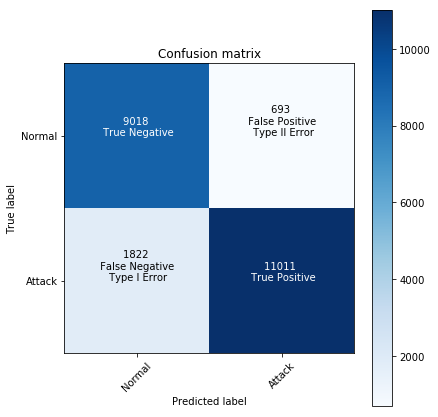

In [26]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [27]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

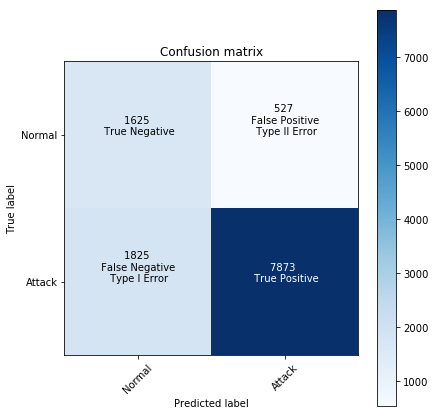

In [28]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [29]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

no_of_features  hidden_layers
1               1                (0.620858304949, 0.841798744397)
                3                (0.578442504538, 0.881341074074)
12              1                                      (nan, nan)
                3                (0.760092317917, 0.916548956428)
24              1                (0.420135021181, 0.955362895992)
                3                (0.721386278662, 0.911819782842)
48              1                                      (nan, nan)
                3                (0.802766024432, 0.917541709845)
122             1                                      (nan, nan)
                3                                      (nan, nan)
dtype: object